In [1]:
%matplotlib inline

import numpy as np
import datacube
import xarray as xr
from odc.algo import to_f32, xr_geomedian, int_geomedian
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_plotting import rgb
from datacube.utils.cog import write_cog
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_gmMADcos import cos_distance, geometric_median
from scipy import stats

### Set up a dask cluster

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:35329 Dashboard: /user/mickwelli/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


In [3]:
dc = datacube.Datacube(app='SiteGMExport')

## Load cloud-masked Sentinel-2 from the datacube

In [7]:
# Set up centre of area of interest, and area to buffer coordinates by
lat, lon = -17.46222222,28.06333333
buffer = 0.05

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2019-07','2019-09'),
    'measurements': ['green',
                     'red',
                     'blue',
                     'nir',
                     'swir_1',
                     'swir_2'],
    'resolution': (-10, 10),
    'group_by': 'solar_day',
    'output_crs': 'EPSG:6933'
}


In [8]:
# Load available data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              dask_chunks={'x':2000, 'y':2000},
              dtype='native',
              **query)

# Print output data
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 18 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 18, x: 965, y: 1219)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-04T08:25:11 ... 2019-09-27T08:...
  * y            (y) float64 -2.188e+06 -2.188e+06 ... -2.2e+06 -2.2e+06
  * x            (x) float64 2.703e+06 2.703e+06 ... 2.713e+06 2.713e+06
    spatial_ref  int32 6933
Data variables:
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    swir_1       (time, y, x) uint16 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    swir_2       (time, y, x) uint16 dask.array<chu

## Inspect the time-series

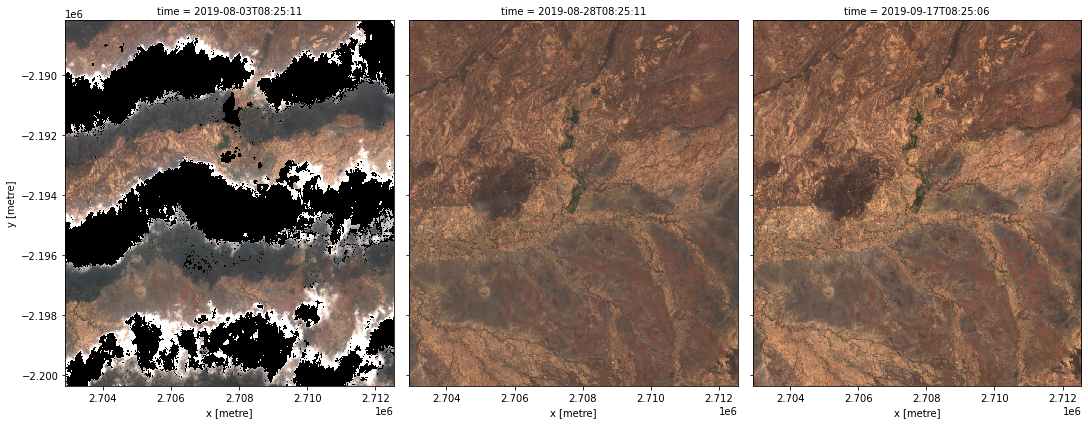

In [9]:
# Set the timesteps to visualise
timesteps = [6,11,15]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)


## Set the scale to compute the geomedian on a xarray

In [10]:
#sr_max_value = 10000                 # maximum value for SR in the loaded product
#scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

#scale the values using the f_32 util function
ds_scaled = to_f32(ds)# scale=scale,
                  # offset=offset)
print(ds_scaled)

<xarray.Dataset>
Dimensions:      (time: 18, x: 965, y: 1219)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-04T08:25:11 ... 2019-09-27T08:...
  * y            (y) float64 -2.188e+06 -2.188e+06 ... -2.2e+06 -2.2e+06
  * x            (x) float64 2.703e+06 2.703e+06 ... 2.713e+06 2.713e+06
    spatial_ref  int32 6933
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
    swir_2       (time, y, x) float32 dask.array<chunksize=(1, 1219, 965), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Compute geomedian

In [28]:
geomedian = xr_geomedian(ds_scaled,
                         num_threads=1,
                         eps=1e-7,
                         ).compute()
print(geomedian)
geomedian

<xarray.Dataset>
Dimensions:  (x: 387, y: 488)
Coordinates:
  * y        (y) float64 -2.192e+06 -2.192e+06 ... -2.197e+06 -2.197e+06
  * x        (x) float64 2.706e+06 2.706e+06 2.706e+06 ... 2.71e+06 2.71e+06
Data variables:
    green    (y, x) float32 1615.315 1923.4453 1718.6941 ... 998.0645 1005.5655
    red      (y, x) float32 2263.6575 2680.831 2422.5789 ... 1516.7583 1529.0411
    blue     (y, x) float32 1179.8086 1349.2653 1222.0867 ... 799.2255 791.5878
    nir      (y, x) float32 3250.6733 3674.2754 3435.762 ... 2355.7551 2457.779
    swir_1   (y, x) float32 4963.304 5165.347 5156.1025 ... 3650.186 3652.414
    swir_2   (y, x) float32 3944.5266 4253.5166 4248.946 ... 2766.4177 2763.1633


<xarray.Dataset>
Dimensions:  (x: 387, y: 488)
Coordinates:
  * y        (y) float64 -2.192e+06 -2.192e+06 ... -2.197e+06 -2.197e+06
  * x        (x) float64 2.706e+06 2.706e+06 2.706e+06 ... 2.71e+06 2.71e+06
Data variables:
    green    (y, x) float32 1615.315 1923.4453 1718.6941 ... 998.0645 1005.5655
    red      (y, x) float32 2263.6575 2680.831 2422.5789 ... 1516.7583 1529.0411
    blue     (y, x) float32 1179.8086 1349.2653 1222.0867 ... 799.2255 791.5878
    nir      (y, x) float32 3250.6733 3674.2754 3435.762 ... 2355.7551 2457.779
    swir_1   (y, x) float32 4963.304 5165.347 5156.1025 ... 3650.186 3652.414
    swir_2   (y, x) float32 3944.5266 4253.5166 4248.946 ... 2766.4177 2763.1633

## Calculate spectral MAD

In [29]:
arrgm = np.array(geomedian.to_array().astype(np.float32))
arrds = np.array(ds.to_array().astype(np.float32))
arrgm = arrgm.astype(np.float32)[:, np.newaxis]
arrds = arrds.astype(np.float32)
cosdist = np.transpose(1-np.nansum(arrgm*arrds,axis=0)/(np.sqrt(np.sum(arrgm ** 2, axis=0)) * np.sqrt(np.nansum(arrds ** 2,axis=0))))
cosdist = xr.DataArray(np.nanmedian(cosdist, axis=2)).to_dataset(name="SMAD").rename({'dim_0':'x','dim_1':'y'}).transpose()
mergeMAD = xr.merge([geomedian, cosdist])
mergeMAD

<xarray.Dataset>
Dimensions:  (x: 387, y: 488)
Coordinates:
  * x        (x) float64 2.706e+06 2.706e+06 2.706e+06 ... 2.71e+06 2.71e+06
  * y        (y) float64 -2.192e+06 -2.192e+06 ... -2.197e+06 -2.197e+06
Data variables:
    green    (y, x) float32 1615.315 1923.4453 1718.6941 ... 998.0645 1005.5655
    red      (y, x) float32 2263.6575 2680.831 2422.5789 ... 1516.7583 1529.0411
    blue     (y, x) float32 1179.8086 1349.2653 1222.0867 ... 799.2255 791.5878
    nir      (y, x) float32 3250.6733 3674.2754 3435.762 ... 2355.7551 2457.779
    swir_1   (y, x) float32 4963.304 5165.347 5156.1025 ... 3650.186 3652.414
    swir_2   (y, x) float32 3944.5266 4253.5166 4248.946 ... 2766.4177 2763.1633
    SMAD     (y, x) float32 0.00038793683 0.00048434734 ... 0.0006096363

In [30]:
mergeMAD = calculate_indices(mergeMAD, index=['NDVI', 'NDWI', 'BSI'], collection='s2')
print(mergeMAD)

<xarray.Dataset>
Dimensions:  (x: 387, y: 488)
Coordinates:
  * x        (x) float64 2.706e+06 2.706e+06 2.706e+06 ... 2.71e+06 2.71e+06
  * y        (y) float64 -2.192e+06 -2.192e+06 ... -2.197e+06 -2.197e+06
Data variables:
    green    (y, x) float32 1615.315 1923.4453 1718.6941 ... 998.0645 1005.5655
    red      (y, x) float32 2263.6575 2680.831 2422.5789 ... 1516.7583 1529.0411
    blue     (y, x) float32 1179.8086 1349.2653 1222.0867 ... 799.2255 791.5878
    nir      (y, x) float32 3250.6733 3674.2754 3435.762 ... 2355.7551 2457.779
    swir_1   (y, x) float32 4963.304 5165.347 5156.1025 ... 3650.186 3652.414
    swir_2   (y, x) float32 3944.5266 4253.5166 4248.946 ... 2766.4177 2763.1633
    SMAD     (y, x) float32 0.00038793683 0.00048434734 ... 0.0006096363
    NDVI     (y, x) float32 0.17899106 0.15632223 ... 0.21665432 0.23295207
    NDWI     (y, x) float32 -0.3360794 -0.31277552 ... -0.40481925 -0.41930956
    BSI      (y, x) float32 0.2398879 0.21932401 ... 0.24176663 0.

### Inspect the geomedian

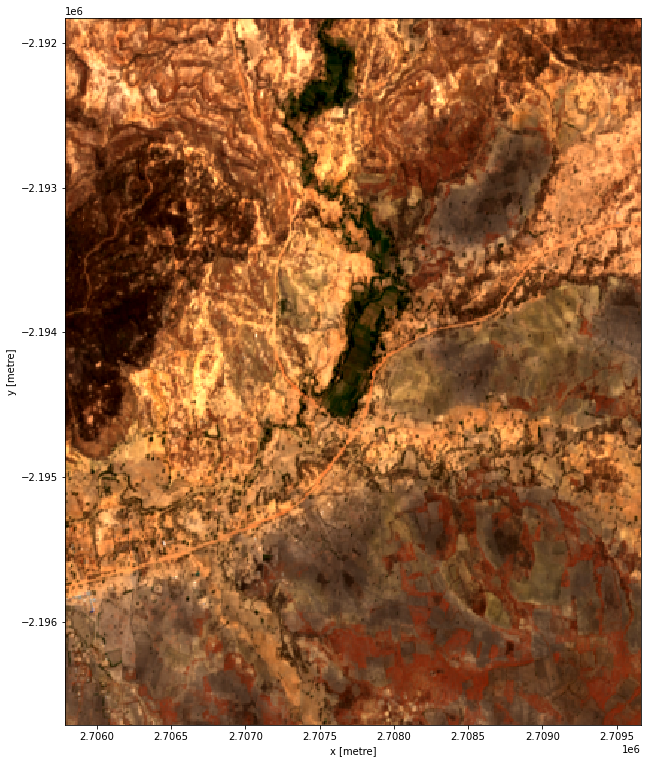

In [31]:
rgb(mergeMAD, size=13)

## Inspect spectral MAD of geomedian

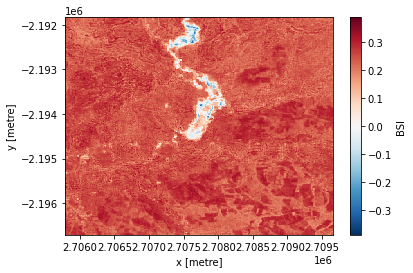

In [32]:
mergeMAD.BSI.plot()

In [33]:
write_cog(mergeMAD.to_array(),
          fname="Nabusenga2019sMADQ3.tif",
          overwrite=True)

PosixPath('Nabusenga2019sMADQ3.tif')